In [1]:
import pandas as pd
import numpy as np
import wrangle
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.feature_selection import RFE

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import wrangle

In [2]:
df = wrangle.wrangle_zillow()
df.head()

,bedrooms,bathrooms,area,tax_value,year_built,tax_amount,fips
0,4,2.0,3633,296425,2005,6941.39,6037
1,3,4.0,1620,847770,2011,10244.94,6037
2,3,2.0,2077,646760,1926,7924.68,6037
3,0,0.0,1200,5328,1972,91.60,6037
4,0,0.0,171,6920,1973,255.17,6037


In [3]:
train_validate, test = train_test_split(df, test_size = 0.10, random_state = 123)
train, validate = train_test_split(train_validate, test_size = 0.20, random_state = 123)
print(train.shape, validate.shape, test.shape)

(1508099, 7) (377025, 7) (209459, 7)


In [4]:
train.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax_value', 'year_built',
       'tax_amount', 'fips'],
      dtype='object')

In [5]:

train.drop(columns = ['bedrooms', 'bathrooms', 'year_built', 'tax_amount', 'fips'], inplace=True)

In [6]:
X_train = train[['area']]
y_train = train['tax_value']

X_validate = validate[['area']]
y_validate = validate['tax_value']

X_test = test[['area']]
y_test = test['tax_value']

In [7]:
X_train

,area
1054933,1451
584421,2604
1242400,1412
1557109,1520
857417,1252
...,...
1460544,892
1217528,2081
883362,1300
3819,936


In [8]:
y_train

1054933    560000
584421     878869
1242400    232923
1557109    201628
857417     613000
            ...  
1460544     30805
1217528    584400
883362     223488
3819       452922
947306      81776
Name: tax_value, Length: 1508099, dtype: int64

In [9]:
baseline = train.tax_value.mean()
baseline

398646.0085040836

In [10]:
train['baseline'] = train.tax_value.mean()
train.head()

,area,tax_value,baseline
1054933,1451,560000,398646.008504
584421,2604,878869,398646.008504
1242400,1412,232923,398646.008504
1557109,1520,201628,398646.008504
857417,1252,613000,398646.008504


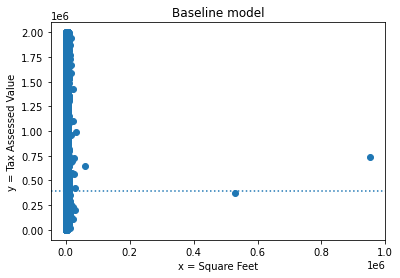

In [11]:
# plot data with baseline:

plt.scatter(train.area, train.tax_value)
plt.axhline(train.tax_value.mean(), ls = ':')
plt.xlabel('x = Square Feet')
plt.ylabel('y = Tax Assessed Value')
plt.title('Baseline model');

In [12]:
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_train)

In [13]:
train['yhat'] = predictions
train.head()

,area,tax_value,baseline,yhat
1054933,1451,560000,398646.008504,363055.327137
584421,2604,878869,398646.008504,481454.397515
1242400,1412,232923,398646.008504,359050.501687
1557109,1520,201628,398646.008504,370140.787550
857417,1252,613000,398646.008504,342620.448555


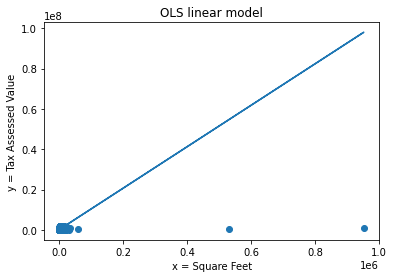

In [14]:
# visualize the line of best fit from OLS linear model
plt.scatter(train.area, train.tax_value)
plt.plot(train.area, train.yhat)
plt.xlabel('x = Square Feet')
plt.ylabel('y = Tax Assessed Value')
plt.title('OLS linear model');

In [15]:
train.head()

,area,tax_value,baseline,yhat
1054933,1451,560000,398646.008504,363055.327137
584421,2604,878869,398646.008504,481454.397515
1242400,1412,232923,398646.008504,359050.501687
1557109,1520,201628,398646.008504,370140.787550
857417,1252,613000,398646.008504,342620.448555


In [16]:
# residual = actual - predicted
train['residual'] = train.tax_value - train.yhat
train['baseline_residual'] = train.tax_value - train.baseline

In [17]:
train.head()

,area,tax_value,baseline,yhat,residual,baseline_residual
1054933,1451,560000,398646.008504,363055.327137,196944.672863,161353.991496
584421,2604,878869,398646.008504,481454.397515,397414.602485,480222.991496
1242400,1412,232923,398646.008504,359050.501687,-126127.501687,-165723.008504
1557109,1520,201628,398646.008504,370140.787550,-168512.787550,-197018.008504
857417,1252,613000,398646.008504,342620.448555,270379.551445,214353.991496


#### Negative Residual = Prediction too high

#### Positive Residual = Prediction too low

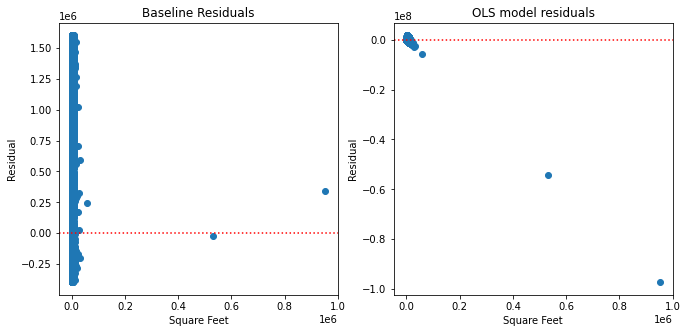

In [18]:
# residual plots (x vs residual)

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(train.area, train.baseline_residual)
plt.axhline(y = 0, ls = ':', color='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(train.area, train.residual)
plt.axhline(y = 0, ls = ':', color ='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('OLS model residuals');

In [19]:
baseline_residual_min = train.baseline_residual.min()
baseline_residual_max = train.baseline_residual.max()
residual_min = train.residual.min()
residual_max = train.residual.max()

In [20]:
residual_min, residual_max

(-97289292.60561499, 1719522.716674683)

Negative Residual = Prediction too high
Positive Residual = Prediction too low


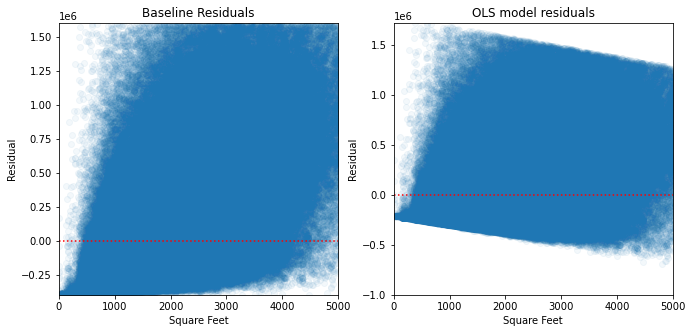

In [21]:
# residual plots (x vs residual)

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(train.area, train.baseline_residual, alpha=.05)
plt.axhline(y = 0, ls = ':', color = 'red')
plt.xlim(0,5000)
plt.ylim(baseline_residual_min, baseline_residual_max)
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(train.area, train.residual, alpha=0.05)
plt.axhline(y = 0, ls = ':', color ='red')
plt.xlim(0,5000)
plt.ylim(-1_000_000, residual_max)
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('OLS model residuals')
print("Negative Residual = Prediction too high")
print("Positive Residual = Prediction too low")

#### Takeaway: Presence of a slope in the residual plot suggests the need for additional predictors

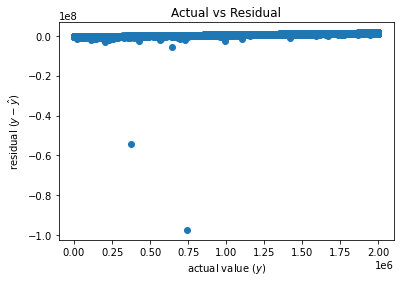

In [22]:
# Residual plot (y vs residual)
actual = train.tax_value
predicted = train.yhat
residuals = actual - predicted
plt.hlines(0, actual.min(), actual.max(), ls=':')
plt.scatter(actual, residuals)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title('Actual vs Residual')
plt.show()

In [23]:
train['residual^2'] = train.residual**2
train['baseline_residual^2'] = train.baseline_residual**2

train.head()

,area,tax_value,baseline,yhat,residual,baseline_residual,residual^2,baseline_residual^2
1054933,1451,560000,398646.008504,363055.327137,196944.672863,161353.991496,3.878720e+10,2.603511e+10
584421,2604,878869,398646.008504,481454.397515,397414.602485,480222.991496,1.579384e+11,2.306141e+11
1242400,1412,232923,398646.008504,359050.501687,-126127.501687,-165723.008504,1.590815e+10,2.746412e+10
1557109,1520,201628,398646.008504,370140.787550,-168512.787550,-197018.008504,2.839656e+10,3.881610e+10
857417,1252,613000,398646.008504,342620.448555,270379.551445,214353.991496,7.310510e+10,4.594763e+10


In [24]:
SSE = train['residual^2'].sum()
SSE_baseline = train['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))

SSE = 125852925480249344.0
SSE Baseline = 148292250643972256.0


In [25]:
SSE < SSE_baseline

True

In [26]:
len(train)
train.shape[0]

1508099

In [27]:
MSE = SSE/len(train)
MSE_baseline = SSE_baseline/len(train)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

MSE =  83451368564.2
MSE baseline =  98330580846.5


In [28]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)


print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

RMSE =  288879.5
RMSE baseline =  313577.1


In [29]:
if SSE < SSE_baseline:
    print('OLS Regression Model Performs Better than Baseline')
else:
    print('OLS Regression Model Performs Worse than Baseline')

OLS Regression Model Performs Better than Baseline


In [30]:

# calculate R2 manually:

# Total Sum of Squares = SSE for baseline
TSS = SSE_baseline = train['baseline_residual^2'].sum()

# Sum of squared error for the regression line (Unexplained error)
SSE = train['residual^2'].sum()

# ESS - Explained sum of squares ('Explained Error')
ESS = TSS - SSE

# Calculate R2
R2 = ESS/TSS
R2

0.151318258818503

In [31]:

# calculate R2 the easy way:

from sklearn.metrics import r2_score
r2_score(train.tax_value, train.yhat)

0.15131825881850303

In [33]:
X2 = sm.add_constant(train.area)
est = sm.OLS(train.tax_value, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:              tax_value   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                 2.689e+05
Date:                Fri, 10 Jun 2022   Prob (F-statistic):               0.00
Time:                        13:51:33   Log-Likelihood:            -2.1102e+07
No. Observations:             1508099   AIC:                         4.220e+07
Df Residuals:                 1508097   BIC:                         4.220e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.141e+05    426.679    501.677      0.0